In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
#import torch.cuda
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal
import math

#conda activate base
cudaOn = False

In [2]:
#Data preparation

In [3]:
tepLoc = "C:/Users/Charlie/Desktop/TEP_Data/"

#tepTrain = tepLoc + "TEP_Faulty_Training.csv"
tepTrain = tepLoc + "TEP_FaultFree_Training.csv"

#tepTest = tepLoc + "TEP_FaultFree_Testing.csv"
tepTest = tepLoc + "TEP_Faulty_Testing.csv"

scaler = MinMaxScaler()

#data = pd.read_csv('c172_file_1.csv')
data = pd.read_csv(tepTrain)
dataTest = pd.read_csv(tepTest)



In [4]:
#lookie = dataTest[dataTest['simulationRun']==112]
#print(lookie[lookie['faultNumber']==5])

In [5]:
data = data.drop('Unnamed: 0',axis=1)
data = data.drop('faultNumber',axis=1)
data = data.drop('simulationRun',axis=1)
#data = data.drop('sample',axis=1)
data

,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,496,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,120.41,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,497,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,120.39,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,498,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,120.41,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,499,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,120.39,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


In [6]:
dataTest = dataTest[dataTest['simulationRun']==287]
faultNumbersT = dataTest.get('faultNumber')
#
dataTest = dataTest.drop('Unnamed: 0',axis=1)
dataTest = dataTest.drop('faultNumber',axis=1)
dataTest = dataTest.drop('simulationRun',axis=1)
#dataTest = dataTest.drop('sample',axis=1)
#dataTest = data
#dataTest = dataTest.iloc(0)[0:19500] #test A and B
#dataTest = dataTest.iloc(0)[19500:38500] #test C and D
#dataTest = dataTest.iloc(0)[39000:58000]

faultNumbersTest = []
for i in faultNumbersT:
    faultNumbersTest.append(i)

data = data.astype('float64')
dataTest = dataTest.astype('float64')

In [7]:
run_length = 960
#num = 960
for i in range(int(len(faultNumbersTest)/run_length)):
    print(str(i*run_length) + ": " + str(faultNumbersTest[i*run_length]))
#print(faultNumbersTest[10000:10100])

0: 1
960: 2
1920: 3
2880: 4
3840: 5
4800: 6
5760: 7
6720: 8
7680: 9
8640: 10
9600: 11
10560: 12
11520: 13
12480: 14
13440: 15
14400: 16
15360: 17
16320: 18
17280: 19
18240: 20


In [8]:
print(dataTest)
numVariables = 53#52

         sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  \
5491200     1.0  0.25125   3671.2   4506.8   9.3936   27.017   41.959   
5491201     2.0  0.25179   3675.5   4531.3   9.3908   26.856   42.319   
5491202     3.0  0.25192   3643.8   4477.5   9.3580   27.143   42.614   
5491203     4.0  0.25098   3692.7   4489.2   9.2897   26.759   42.382   
5491204     5.0  0.25060   3671.0   4494.0   9.3513   26.806   42.364   
...         ...      ...      ...      ...      ...      ...      ...   
5510395   956.0  0.28423   3670.1   4547.2   9.3799   26.653   42.679   
5510396   957.0  0.31097   3654.7   4501.9   9.3478   26.925   42.317   
5510397   958.0  0.31154   3654.9   4503.4   9.3675   26.761   42.442   
5510398   959.0  0.29657   3691.6   4478.4   9.3266   27.175   42.251   
5510399   960.0  0.29850   3684.3   4469.1   9.4297   26.814   42.286   

         xmeas_7  xmeas_8  xmeas_9  ...   xmv_2   xmv_3   xmv_4   xmv_5  \
5491200   2705.8   75.092   120.39  ...  54.010 

In [9]:
#Helper Methods

In [10]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    #print(int((len(data)/step_size)))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

In [11]:
#Model

In [12]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(tensorZ.shape)
        #print(z[0])

        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [13]:
#Model Setup

In [14]:
step_size = 3
batch = 512
index_step_length = numVariables
epochs = 20

num = 10

d = 2
k = 1

base_mu, base_cov = torch.zeros(2), torch.eye(2)

base_mu = torch.nn.parameter.Parameter(to_var(base_mu.double()))
base_cov = torch.nn.parameter.Parameter(to_var(base_cov.double()))
#base_mu = torch.nn.parameter.Parameter(base_mu,requires_grad=True)
#base_cov = torch.nn.parameter.Parameter(base_cov,requires_grad=True)
print(base_mu)
print(base_cov)
base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=13,z_dim=2)
model = stacked_NVP(d, k, hidden=108,n=num)
demo.double()
model.double()
    
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)
optimizer3 = torch.optim.RMSprop([base_mu,base_cov], lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

if torch.cuda.is_available() & cudaOn:
    demo.cuda()
    print("demo done")
    model.cuda()
    print("model done")

Parameter containing:
tensor([0., 0.], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[1., 0.],
        [0., 1.]], dtype=torch.float64, requires_grad=True)


In [15]:
#Model Training

In [16]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        optimizer.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        localX = to_var(torch.tensor(b[i]))
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""

        loss.backward()
        
        optimizer.step()
        optimizer2.step()
        optimizer3.step()
        scheduler.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = abs(torch.mean(localX-recon))

        if idx%30 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))

C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20] Loss: 0.217
Epoch[1/20] Loss: 0.215
Epoch[1/20] Loss: 0.215
Epoch[1/20] Loss: 0.214
Epoch[1/20] Loss: 0.215
Epoch[2/20] Loss: 0.215
Epoch[2/20] Loss: 0.215
Epoch[2/20] Loss: 0.215
Epoch[2/20] Loss: 0.215
Epoch[2/20] Loss: 0.215
Epoch[3/20] Loss: 0.215
Epoch[3/20] Loss: 0.215
Epoch[3/20] Loss: 0.215
Epoch[3/20] Loss: 0.215
Epoch[3/20] Loss: 0.215
Epoch[4/20] Loss: 0.215
Epoch[4/20] Loss: 0.215
Epoch[4/20] Loss: 0.215
Epoch[4/20] Loss: 0.215
Epoch[4/20] Loss: 0.215
Epoch[5/20] Loss: 0.214
Epoch[5/20] Loss: 0.216
Epoch[5/20] Loss: 0.215
Epoch[5/20] Loss: 0.215
Epoch[5/20] Loss: 0.215
Epoch[6/20] Loss: 0.216
Epoch[6/20] Loss: 0.216
Epoch[6/20] Loss: 0.215
Epoch[6/20] Loss: 0.215
Epoch[6/20] Loss: 0.215
Epoch[7/20] Loss: 0.215
Epoch[7/20] Loss: 0.215
Epoch[7/20] Loss: 0.215
Epoch[7/20] Loss: 0.216
Epoch[7/20] Loss: 0.216
Epoch[8/20] Loss: 0.215
Epoch[8/20] Loss: 0.215
Epoch[8/20] Loss: 0.215
Epoch[8/20] Loss: 0.215
Epoch[8/20] Loss: 0.215
Epoch[9/20] Loss: 0.215
Epoch[9/20] Loss

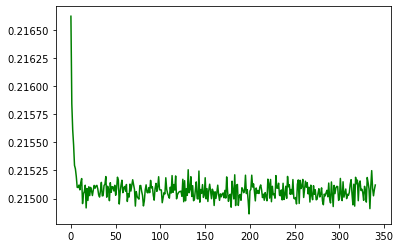

In [17]:
p = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')

In [18]:
"""
t1 = tep_testing_stepped(dataTest,step_size)
step_start = 0
anomalies = []
y_nomalies = []
county = 0
setNum = 0
for step in t1:
    step = to_var(torch.tensor(step,dtype=torch.float64))
    recon,_,_ = demo(step)
    anom = abs(torch.mean(step-recon))
    anom2 = torch.mean(torch.tensor(faultNumbersTest[county:county+step_size],dtype=torch.float64))
    anomalies.append(anom)
    y_nomalies.append(anom2)
    step_start = step_start + 1
    county = county + step_size
p3 = plt.figure()
plt.plot(anomalies, 'g-')
p4 = plt.figure()
plt.plot(y_nomalies, 'b-')
"""

"\nt1 = tep_testing_stepped(dataTest,step_size)\nstep_start = 0\nanomalies = []\ny_nomalies = []\ncounty = 0\nsetNum = 0\nfor step in t1:\n    step = to_var(torch.tensor(step,dtype=torch.float64))\n    recon,_,_ = demo(step)\n    anom = abs(torch.mean(step-recon))\n    anom2 = torch.mean(torch.tensor(faultNumbersTest[county:county+step_size],dtype=torch.float64))\n    anomalies.append(anom)\n    y_nomalies.append(anom2)\n    step_start = step_start + 1\n    county = county + step_size\np3 = plt.figure()\nplt.plot(anomalies, 'g-')\np4 = plt.figure()\nplt.plot(y_nomalies, 'b-')\n"

19200
////////////////////
0 : 960
960 : 1920
1920 : 2880
2880 : 3840
3840 : 4800
4800 : 5760
5760 : 6720
6720 : 7680
7680 : 8640
8640 : 9600
9600 : 10560
10560 : 11520
11520 : 12480
12480 : 13440
13440 : 14400
14400 : 15360
15360 : 16320
16320 : 17280
17280 : 18240
18240 : 19200
////////////////////
319

1.3417679071426392
0.33181676268577576
0.0009201765060424805
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
319

1.3059650659561157
0.5618379712104797
0.0011720657348632812
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
319

1.2245630025863647
0.5839540958404541
0.000624

C:\Users\Charlie\AppData\Local\Temp/ipykernel_16388/1338672961.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  p5 = plt.figure()


319

1.1616477966308594
0.25495535135269165
3.355741500854492e-05
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
319

1.2198898792266846
0.5731870532035828
0.00014340877532958984
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
319

1.2684133052825928
0.5053362846374512
0.0005955100059509277
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
319

1.2183880805969238
0.593

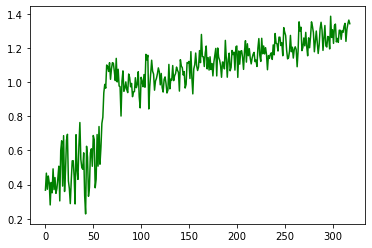

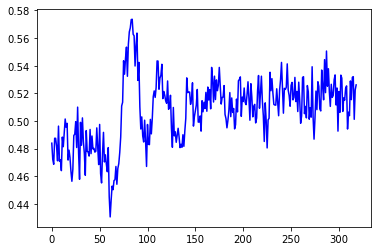

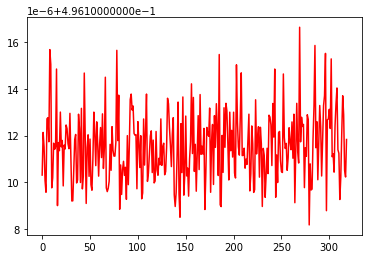

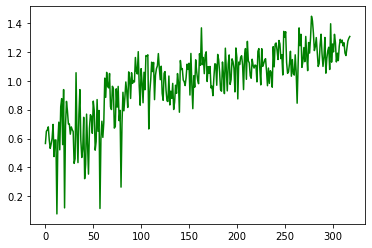

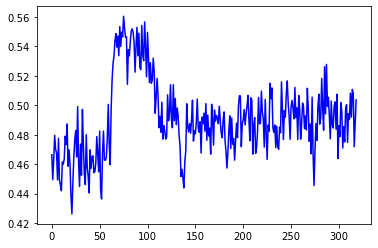

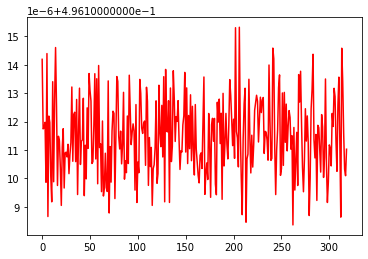

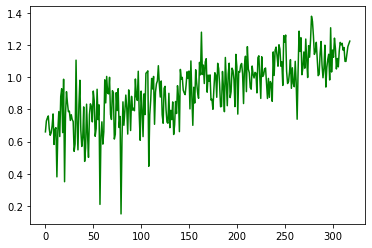

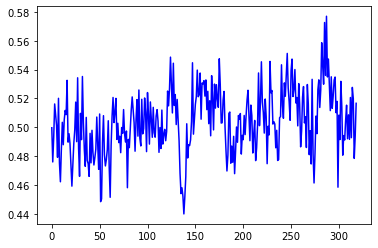

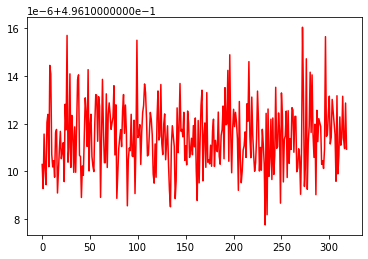

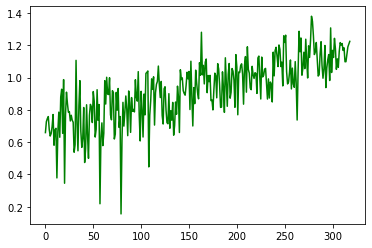

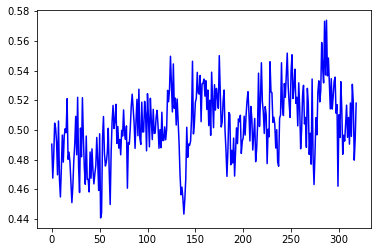

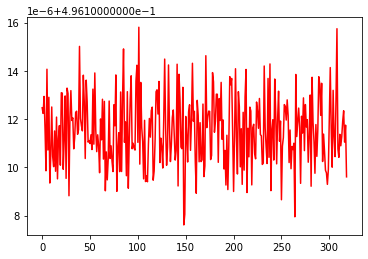

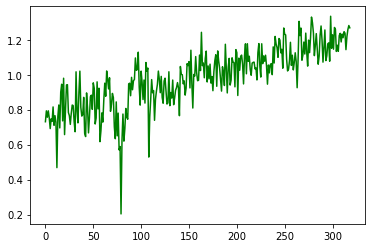

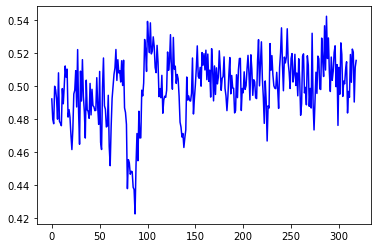

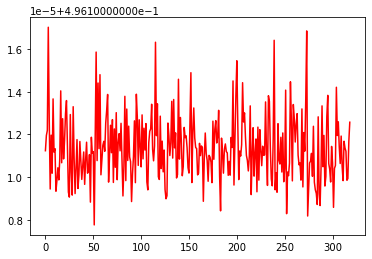

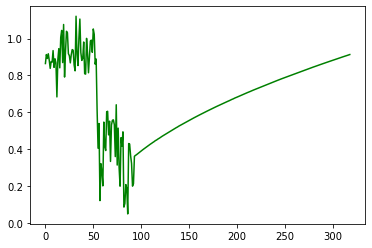

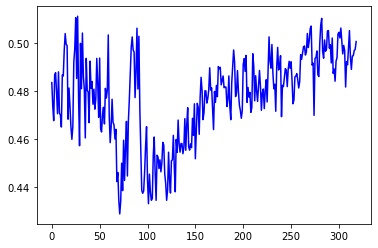

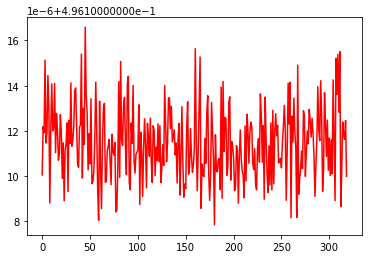

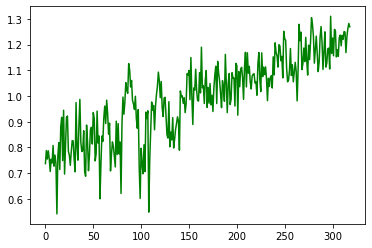

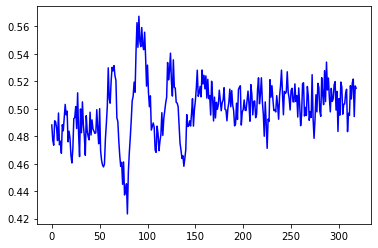

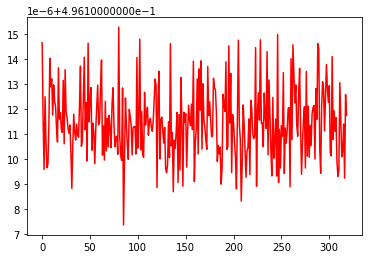

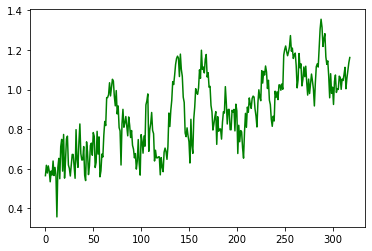

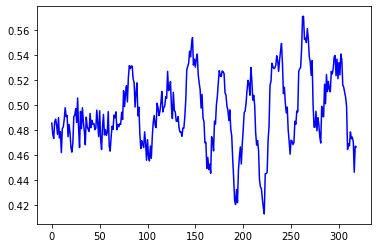

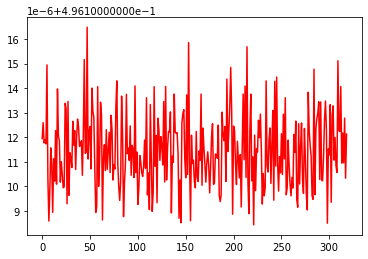

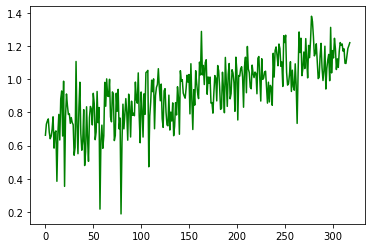

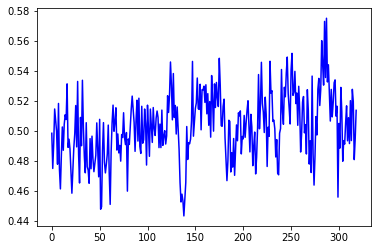

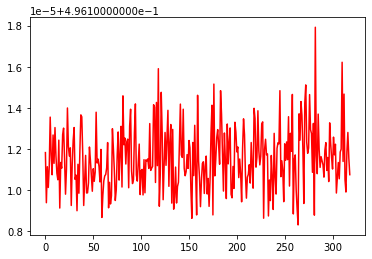

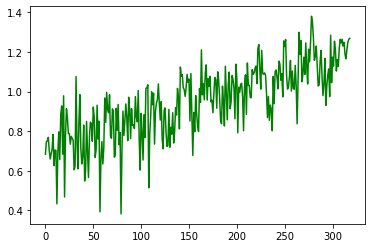

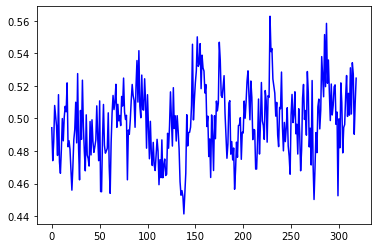

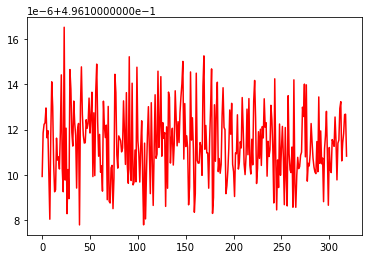

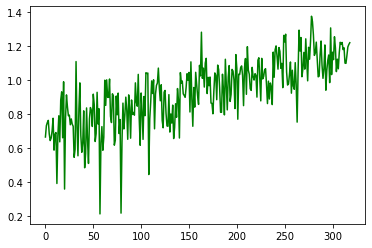

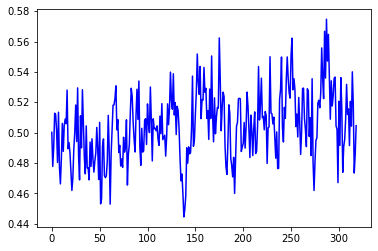

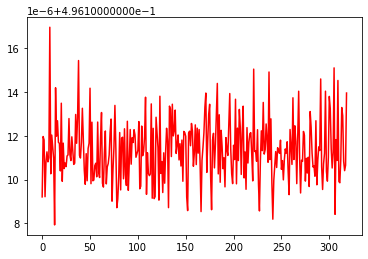

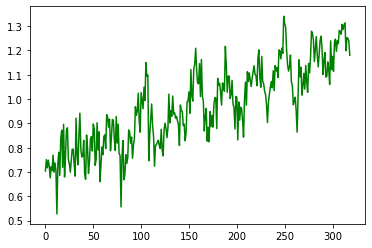

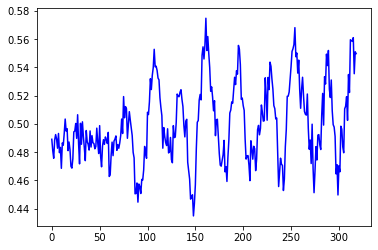

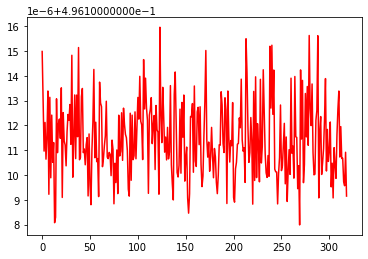

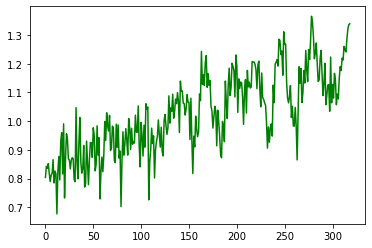

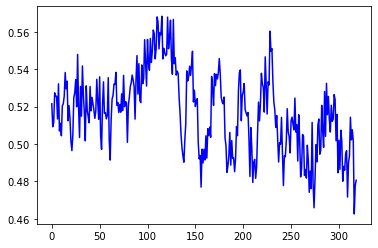

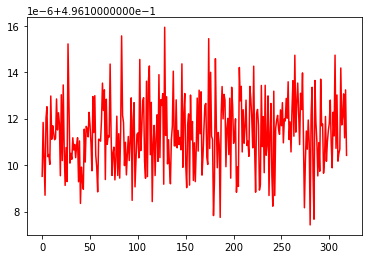

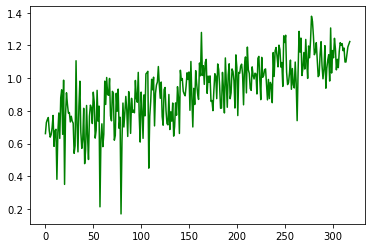

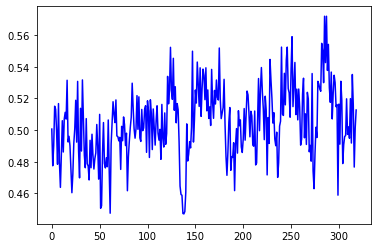

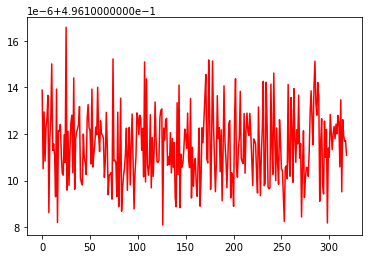

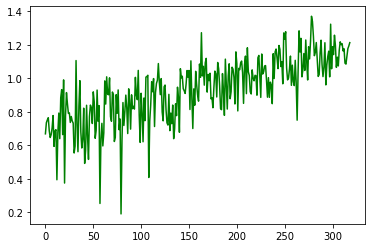

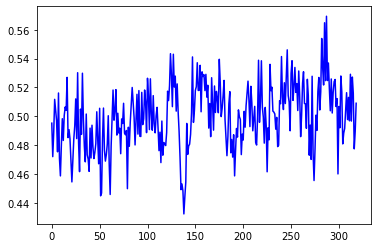

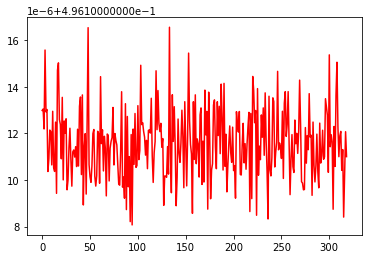

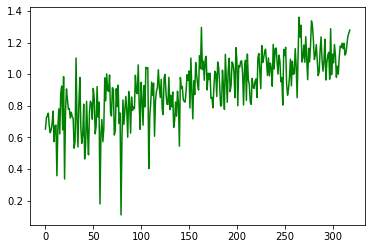

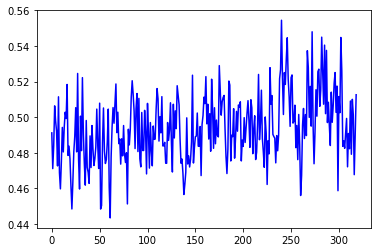

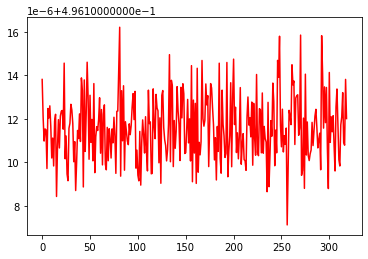

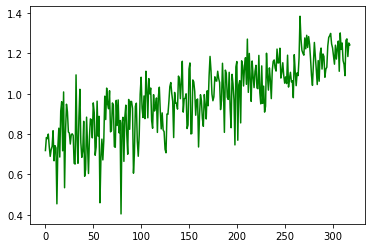

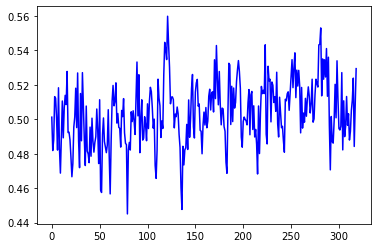

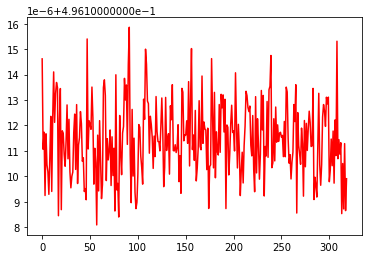

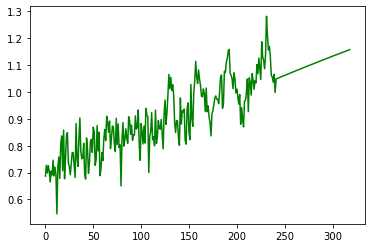

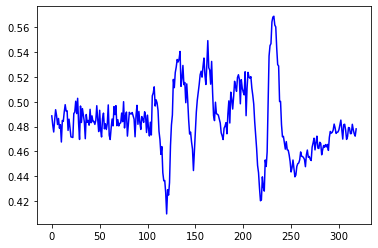

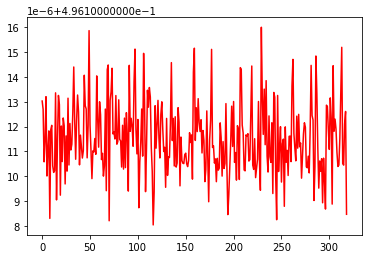

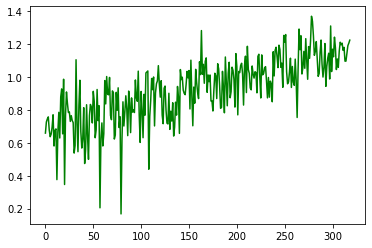

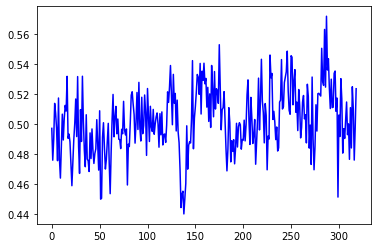

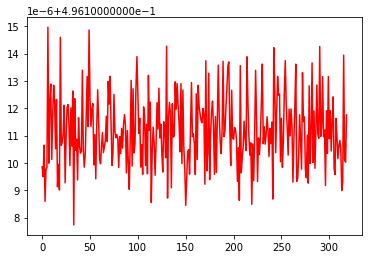

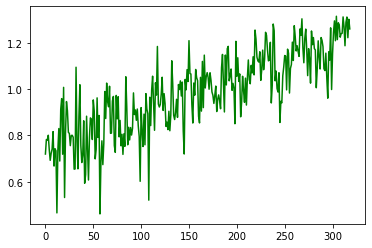

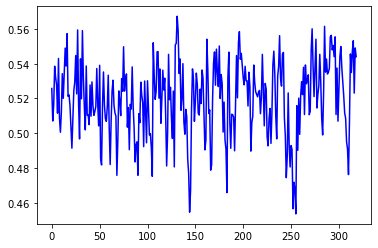

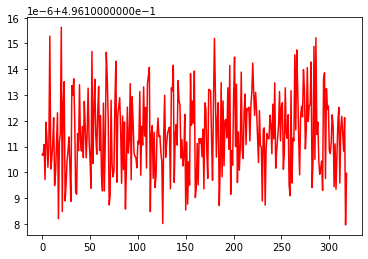

In [19]:
loc = "C:/Users/Charlie/Desktop/picsForDemo2/tepGeneratedNeat/"

strtOfTwo = int(len(dataTest)/20)
sets = []
runNum = 0 
print(len(faultNumbersTest))

print("////////////////////")
for i in range(20):
    print(str(strtOfTwo*runNum) + " : " + str((strtOfTwo*runNum)+run_length))
    #print(faultNumbersTest[strtOfTwo*runNum])
    dt = dataTest[strtOfTwo*runNum:(strtOfTwo*runNum)+run_length]
    t1 = tep_testing_stepped(dt,step_size)
    sets.append(t1)
    runNum = runNum + 1
print("////////////////////")

setNum = 0
for set in sets:
    setName = "anom" + str(setNum+1) + "_Faulty_1"
    fileLoc = loc + setName + ".png"
    step_start = 0
    anomalies = []
    y_nomalies = []
    vals = []
    pred_vals = []
    county = 0
    #print(type(XX))
    #print(len(XX))
    #print(XX.shape)
    for step in set:
      step = to_var(torch.tensor(step,dtype=torch.float64))
      if True:
          #step = torch.tensor(XX[step_start:step_start+step_size])[0]
          recon,_,_ = demo(step)
          a = 1
          #b = 1
          for j in range(len(step)):
            a = a + (step[0][j] - recon[0][j])
            #b = b * recon[0][j]
          #anom = abs(torch.mean(step-recon))
          #print("-------------: " + str(torch.mean(step-recon)))
          #print(str(a) + ",    " + str(b))
          anom = a
          anom2 = torch.mean(torch.tensor(faultNumbersTest[(setNum*strtOfTwo)+(county*step_size):(setNum*strtOfTwo)+(county*step_size+step_size)],dtype=torch.float64))
          #if county%100 == 0:
            #print("step: " + str(step))
            #print("recon: " + str(recon))
            #print(anom)
          anomalies.append(torch.tensor(math.sqrt(abs(anom))))
          y_nomalies.append(anom2)
          pred_vals.append(torch.mean(recon))
          vals.append(torch.mean(step))
          step_start = step_start + 1
          county = county + 1
    setNum = setNum + 1
    start = 0
    view = []
    max = -99999
    min = 99999
    maxA = -99999
    minA = 99999

    print(len(anomalies))

    for a in anomalies:
        if start+1 < len(anomalies):
            view.append(abs(anomalies[start+1].item() - a.item()))  
            start = start + 1

    for i in range(len(view)):
        j = i + 1
        if view[i] > max:
            max = a.item()
        if view[i] < min:
            min = a.item()
        if i < len(view)-1:
            #print("i: " + str(view[i]))
            #print("j: " + str(view[j]))
            v = abs(view[i]-view[j])
            #print("v: " + str(v))
            if v > maxA:
                maxA = v
            if v < minA:
                minA = v

    print()
    print(max)
    print(maxA)
    print(minA)

    #could get loc min and max given a step size rather than literally between individual points

    p3 = plt.figure()
    plt.plot(anomalies, 'g-')
    plt.savefig(fileLoc)
    p4 = plt.figure()
    #plt.plot(y_nomalies, 'b-')
    plt.plot(vals, 'b-')
    p5 = plt.figure()
    plt.plot(pred_vals, 'r-')
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")